In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression as LR
from scipy import stats 
import pickle
from datascience import *
#import pymc3 as pm 
#from pymc3 import * 
%matplotlib inline
import seaborn as sns 
import statsmodels.api as sm

In [ ]:
dem_raw = "https://raw.githubusercontent.com/prasannguruprasad/d102-final-project/main/dem_candidates.csv"

In [ ]:
df = pd.read_csv(dem_raw,index_col=0,parse_dates=[0])

In [ ]:
df.iloc[:,11:18]

,Race,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?
Candidate,,,,,,,
Anthony White (Alabama),Nonwhite,Yes,No,No,No,No,No
Christopher Countryman,White,No,Yes,No,No,No,No
"Doug ""New Blue"" Smith",White,Yes,No,No,No,No,No
James C. Fields,Nonwhite,Yes,No,Yes,No,No,No
Sue Bell Cobb,White,No,No,Yes,No,No,No
...,...,...,...,...,...,...,...
Talley Sergent,White,No,No,No,No,No,Yes
Janice Hagerman,White,No,No,No,No,No,No
Paul Davis,White,No,No,No,No,No,No


In [ ]:
df.groupby("Race")["Primary %"].mean().values

array([ 27.79955671,  32.10260178])

In [ ]:
df.iloc[:,11:18]
indicators = ['Race','Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?','Obama Alum?']
obs_values = dict.fromkeys(indicators)
for ind in indicators:
  grouped = df.groupby(ind)["Primary %"].mean().values
  obs_values[ind] = float(np.diff(grouped))

In [ ]:
def ab_test(id):
  shuffled_vals = df[id].sample(len(df)).values
  reconfig = {"candidate":df.index,"primary%":df['Primary %'],"identifier": shuffled_vals}
  shuffled = pd.DataFrame(reconfig).groupby("identifier")["primary%"].mean().values
  return float(np.diff(shuffled))

In [ ]:
def run_ab(id):
  ts = make_array()
  for i in range(1000):
    ts = np.append(ts,ab_test(id))
  return ts


In [ ]:
obs_values

{'Race': 4.303045068394447,
 'Veteran?': -0.07423040192923835,
 'LGBTQ?': -5.30579156913571,
 'Elected Official?': 8.72634059553928,
 'Self-Funder?': -0.861295792935497,
 'STEM?': -4.0127154963880045,
 'Obama Alum?': 4.62362736231071}

In [ ]:
sim_values = dict.fromkeys(indicators)
for indicator in indicators:
  test_stats = run_ab(indicator)
  sim_values[indicator] = test_stats

In [ ]:
def p_val_greater(indicator):
  '''when high values of the test statistic support the alternative hypothesis'''
  #only applicable to "Race", "Elected Official?", and "Obama Alum?"
  return np.count_nonzero(sim_values[indicator]>=obs_values[indicator])/len(sim_values[indicator])

def p_val_lesser(indicator):
  '''when low values of the test statistic support the alternative hypothesis'''
  return np.count_nonzero(sim_values[indicator]<=obs_values[indicator])/len(sim_values[indicator])

In [ ]:
#naive conclusions
p_vals = []
for ind in indicators:
  if ind in ["Race","Elected Official?","Obama Alum?"]:
    p_vals += [p_val_greater(ind)]
  else:
    p_vals += [p_val_lesser(ind)]

p_values = {'p-value': p_vals}
n_df = pd.DataFrame(range(7))
n_df['Feature'] = pd.DataFrame(indicators)
n_df['p-value'] = p_values['p-value']
n_df["reject null"] = [p<=0.05 for p in p_values['p-value']]
print(n_df[["Feature", "p-value","reject null"]])

             Feature  p-value  reject null
0               Race    0.021         True
1           Veteran?    0.487        False
2             LGBTQ?    0.113        False
3  Elected Official?    0.001         True
4       Self-Funder?    0.432        False
5              STEM?    0.042         True
6        Obama Alum?    0.161        False


Bonferroni Correction For FWER Control

In [ ]:
p_values = {'p-value': p_vals}
df = pd.DataFrame(data=p_values)
df['Feature'] = indicators

# Perform Bonferroni correction
alpha = 0.05
n = len(df)  # Number of hypotheses
df['p-value corrected'] = np.minimum(df['p-value'] * n, 1)  # Bonferroni correction
df['reject null'] = df['p-value corrected'] <= alpha  # Boolean to reject or not reject null hypothesis

print(df[['Feature', 'p-value', 'reject null']])
print("Significance Level : \u03B1 = ", alpha)
print("Bonferroni Correction p-value threshold : ", alpha/n)

             Feature  p-value  reject null
0               Race    0.021        False
1           Veteran?    0.487        False
2             LGBTQ?    0.113        False
3  Elected Official?    0.001         True
4       Self-Funder?    0.432        False
5              STEM?    0.042        False
6        Obama Alum?    0.161        False
Significance Level : α =  0.05
Bonferroni Correction p-value threshold :  0.0071428571428571435


Benjamini Hochberg Procedure to Control FDR

In [ ]:
p_values = {'p-value': p_vals}
df = pd.DataFrame(data=p_values)
df['Feature'] = indicators
df = df.sort_values(by='p-value')
df['k'] = range(1, len(df)+1)

# draw the line y=k*0.05/7
line = df['k'] * 0.05 / 7

# find the largest p-value that falls under the line
largest_p_value = df[df['p-value'] <= line].max()['p-value']

# add a column to the dataframe indicating whether the null hypothesis is rejected or not based on the largest p-value
df['reject_null'] = df['p-value'] <= largest_p_value

# output the dataframe
df[['k', 'Feature', 'p-value', 'reject_null']]

,k,Feature,p-value,reject_null
3,1,Elected Official?,0.001,True
0,2,Race,0.021,False
5,3,STEM?,0.042,False
2,4,LGBTQ?,0.113,False
6,5,Obama Alum?,0.161,False
4,6,Self-Funder?,0.432,False
1,7,Veteran?,0.487,False


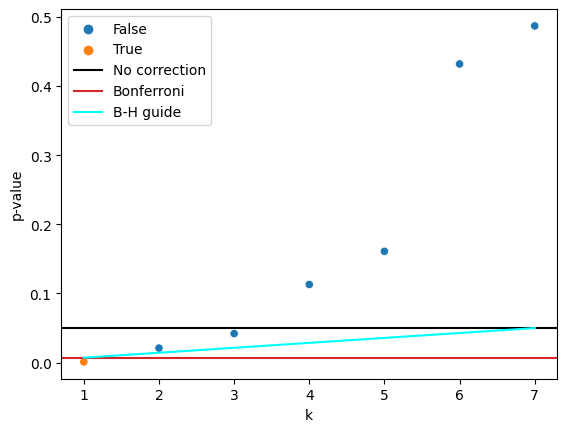

In [ ]:
sns.scatterplot(x=df['k'], y=df['p-value'], hue=df['reject_null']);
plt.axhline(alpha, label='No correction', color='black')
plt.axhline(alpha / 7, label='Bonferroni', color='tab:red')
plt.plot(df['k'], df['k']/7 * alpha, label='B-H guide', color='cyan')
plt.legend();

With both the Benjamini-Hochberg and Bonferroni corrections, we reject the null that the Yes and No responses to the "Elected Official?" personal identifier have the same distribution of percentage vote received in the primaries. We failed to be reject the null hypothesis when working with all other personal identifiers with the corrections. 

With the naive alpha threshold, however, we also rejected the null for the "Race" and "STEM?" identifiers which was not the case when the two corrections are respectively applied. 

In [ ]:
df2 = df = pd.read_csv(dem_raw,index_col=0,parse_dates=[0])
df2 = df2.fillna(0).replace("No", 0).replace("Yes", 1).replace("White", 0).replace("Nonwhite", 1).replace("Governor", 0).replace("Representative", 2).replace("Senator", 1)
cols_endorsements = ['Emily Endorsed?', 'Guns Sense Candidate?', 'Biden Endorsed?', 
                     'Warren Endorsed? ', 'Sanders Endorsed?', 'Our Revolution Endorsed?', 
                     'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
                     'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?']
new_col = np.zeros(df2.shape[0])

for col in cols_endorsements: 
    new_col = new_col + df2[col]

df2["Total Endorsements"] = new_col.astype("int64")

In [ ]:
endorsed = df2[["Total Endorsements", "Primary %", "Partisan Lean", "Office Type"]]
endorsed = endorsed.reset_index()
endorsed.drop(["Candidate"], axis=1)

,Total Endorsements,Primary %,Partisan Lean,Office Type
0,0,3.420000,-28.879999,0
1,0,1.740000,-28.879999,0
2,0,3.270000,-28.879999,0
3,0,8.000000,-28.879999,0
4,0,28.980000,-28.879999,0
...,...,...,...,...
806,0,62.570000,-35.330002,2
807,0,7.240000,-47.480000,2
808,0,15.960000,-47.480000,2
809,2,52.160000,-47.480000,2


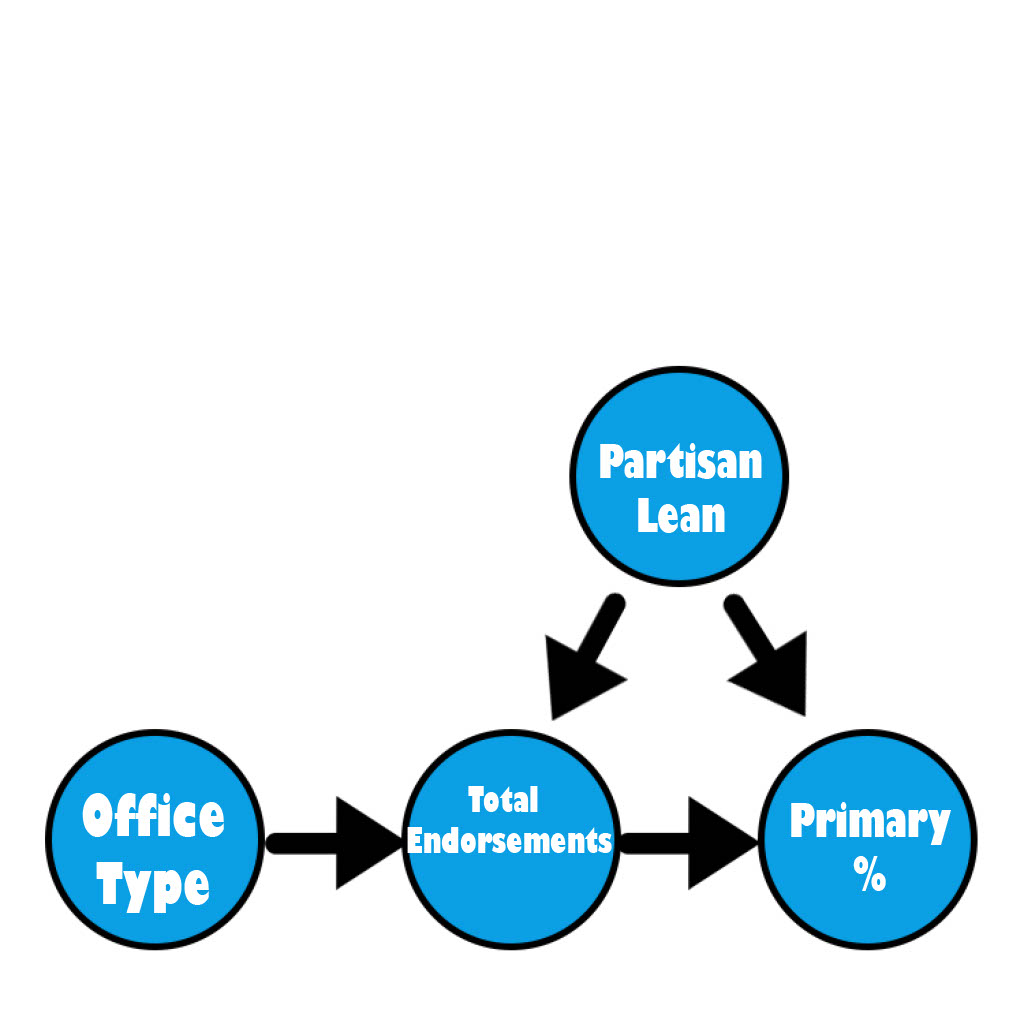

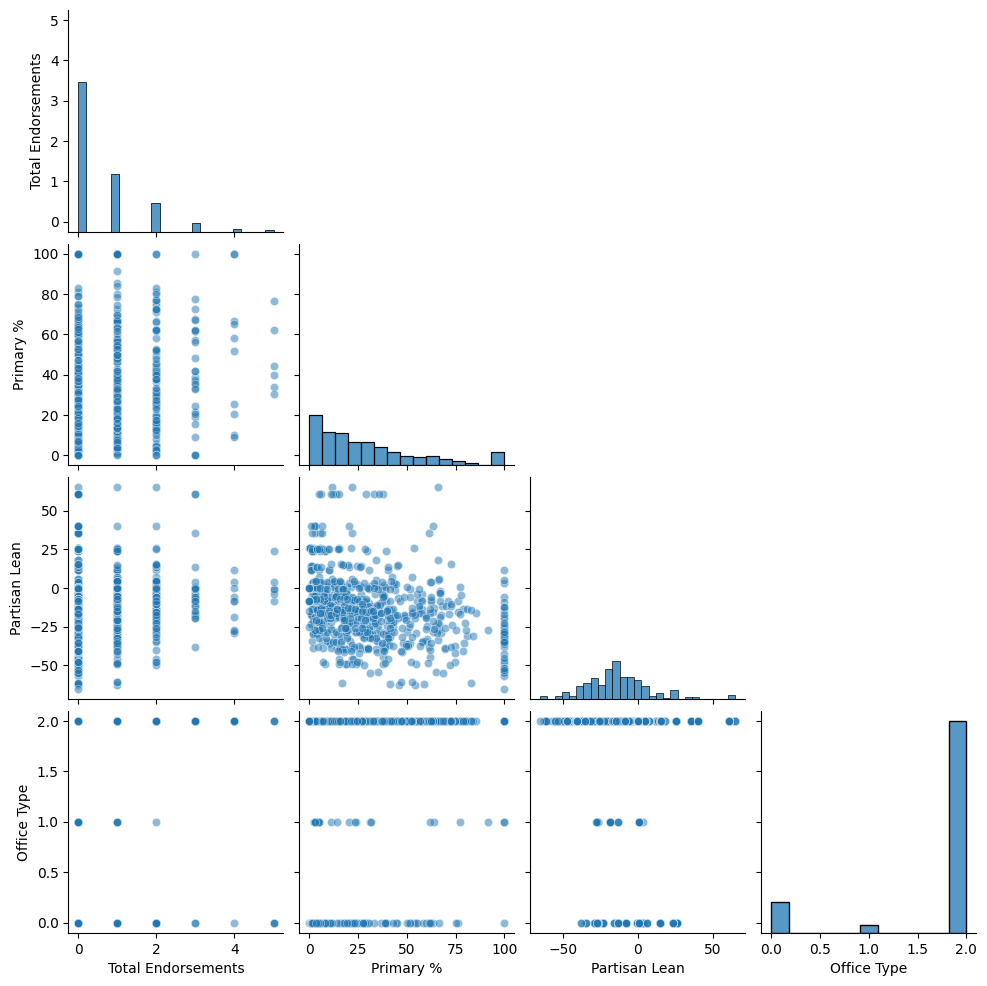

In [ ]:
fig = sns.pairplot(endorsed,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

<Axes: xlabel='Total Endorsements', ylabel='Primary %'>

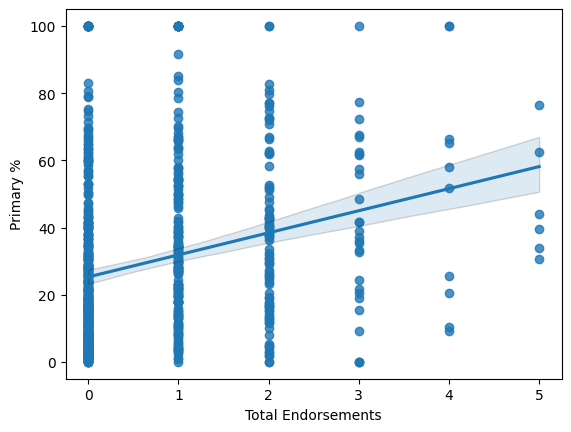

In [ ]:
sns.regplot(data=endorsed, x='Total Endorsements', y='Primary %') 

In [ ]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [ ]:
model = fit_OLS_model(endorsed, 'Primary %', ['Total Endorsements', 'Partisan Lean', 'Office Type'])
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              Primary %   R-squared (uncentered):                   0.629
Model:                            OLS   Adj. R-squared (uncentered):              0.628
Method:                 Least Squares   F-statistic:                              456.9
Date:                Mon, 08 May 2023   Prob (F-statistic):                   1.66e-173
Time:                        22:13:22   Log-Likelihood:                         -3730.9
No. Observations:                 811   AIC:                                      7468.
Df Residuals:                     808   BIC:                                      7482.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

The estimated causal effect of primary vote percentage of an additional endorsement is about 9.3% of the vote. The Partisan Lean has a very small estimated causal effect of a -0.5% of the vote. Finally the office type has a smaller estimated causal effect than the total endorsements but still adds 8.8% primary vote percantage depending on the office.